# Person of Interest (POI) Classifier for Enron Data

Qingyu Li

## 1. Project Overview

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. In this project, we will find features that provide useful information and build a person of interest identifier. We will test the accuracy of prediction of our classifier and find the best predicting model.

## 2. Data Preparation

In [1]:
import sys
import pickle
import numpy
import pandas as pd
import matplotlib

from ggplot import *

sys.path.append("../tools/")

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from feature_format import featureFormat, targetFeatureSplit

target_label = 'poi'
email_features_list = [
    # 'email_address', # remit email address; informational label
    'from_messages',
    'from_poi_to_this_person',
    'from_this_person_to_poi',
    'shared_receipt_with_poi',
    'to_messages',
    ]
financial_features_list = [
    'bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    'exercised_stock_options',
    'expenses',
    'loan_advances',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'restricted_stock_deferred',
    'salary',
    'total_payments',
    'total_stock_value',
]
features_list = [target_label] + financial_features_list + email_features_list

In [2]:
### Load the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )
## Load POI names file
poi = open("poi_names.txt", "r")

How many people are in the dataset?

In [3]:
len(data_dict.keys())

146

How many features are in the dataset?

In [4]:
len(data_dict.values()[0])

21

From the above, we can see that there are 146 people in this dataset and 21 features in total. Next we print out an example of the data point for better understanding.

In [5]:
data_dict[data_dict.keys()[0]]

{'bonus': 600000,
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'mark.metts@enron.com',
 'exercised_stock_options': 'NaN',
 'expenses': 94299,
 'from_messages': 29,
 'from_poi_to_this_person': 38,
 'from_this_person_to_poi': 1,
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 1740,
 'poi': False,
 'restricted_stock': 585062,
 'restricted_stock_deferred': 'NaN',
 'salary': 365788,
 'shared_receipt_with_poi': 702,
 'to_messages': 807,
 'total_payments': 1061827,
 'total_stock_value': 585062}

Convert data into data frame:

In [6]:
# remove outlier key-value pair (errant total)
data_dict.pop('TOTAL',0)
data_dict.pop('LOCKHART EUGENE E', 0)
# reload data after cleaning data outlier using pop to remove TOTAL line
df=pd.DataFrame.from_records(list(data_dict.values()))

First by eyebowing the data, I decided to remove the total row and one row with person name "Lockhart Eugene E" that has all the missing values. 

In [7]:
df.shape

(144, 21)

After removing the total line and the person with all NaN values, there are 144 key executives in the dataset with 21 features.

In [8]:
len(df[df['poi']==1])

18

There are 18 person of interest labeled in the dataset. 

### 2.1 Missing Values

We can see that the missing value are coded as 'NaN'. Next we will need to deal with the 'NaN' and outliers.

In [9]:
df.head()

,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,600000,NaN,NaN,NaN,mark.metts@enron.com,NaN,94299,29,38,1,...,NaN,1740,False,585062,NaN,365788,702,807,1061827,585062
1,1200000,1295738,-1386055,NaN,NaN,6680544,11200,NaN,NaN,NaN,...,1586055,2660303,False,3942714,NaN,267102,NaN,NaN,5634343,10623258
2,350000,NaN,-400729,NaN,steven.elliott@enron.com,4890344,78552,NaN,NaN,NaN,...,NaN,12961,False,1788391,NaN,170941,NaN,NaN,211725,6678735
3,NaN,NaN,NaN,NaN,bill.cordes@enron.com,651850,NaN,12,10,0,...,NaN,NaN,False,386335,NaN,NaN,58,764,NaN,1038185
4,1500000,NaN,-3117011,NaN,kevin.hannon@enron.com,5538001,34039,32,32,21,...,1617011,11350,True,853064,NaN,243293,1035,1045,288682,6391065


In [10]:
# Convert to numpy nan
df.replace(to_replace='NaN', value=numpy.nan, inplace=True)
df.isnull().sum()

bonus                         63
deferral_payments            106
deferred_income               96
director_fees                128
email_address                 33
exercised_stock_options       43
expenses                      50
from_messages                 58
from_poi_to_this_person       58
from_this_person_to_poi       58
loan_advances                141
long_term_incentive           79
other                         52
poi                            0
restricted_stock              35
restricted_stock_deferred    127
salary                        50
shared_receipt_with_poi       58
to_messages                   58
total_payments                20
total_stock_value             19
dtype: int64

The above table prints out the number of NaNs for each features. We can see that the variables with most missing values are director fees and loan advances. In dealing with the missing data, I decided to remove variables that have more than 80% data missing. The reasoning is that since there are 144 people in the dataset, if a variable has more than 80% of the data points missing, it cannot provide enough information for training classifiers. For variables that have less missing values, we will use imputation using the median of that variable. 144*.8=115.2

I decided to impute using median value since there are some extreme values that skewed the distribution. Therefore, median is more appropriate.

In [11]:
import sklearn
# Removing column from database if counter > 116
for column, series in df.iteritems():
    if series.isnull().sum() >= 116:
        df.drop(column, axis=1, inplace=True)
# Drop email address column
if 'email_address' in list(df.columns.values):
    df.drop('email_address', axis=1, inplace=True)

impute = sklearn.preprocessing.Imputer(missing_values=numpy.nan, strategy='median', axis=0)
impute.fit(df)
df_imputed = pd.DataFrame(impute.transform(df.copy(deep=True)))
df_imputed.columns = list(df.columns.values)

In [12]:
print df_imputed.shape

(144, 17)


In [13]:
print features_list

['poi', 'bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'total_payments', 'total_stock_value', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'to_messages']


In [14]:
len(features_list)

20

In [15]:
features_list.remove('loan_advances')
features_list.remove('director_fees')
features_list.remove('restricted_stock_deferred')

In [16]:
print features_list

['poi', 'bonus', 'deferral_payments', 'deferred_income', 'exercised_stock_options', 'expenses', 'long_term_incentive', 'other', 'restricted_stock', 'salary', 'total_payments', 'total_stock_value', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'to_messages']


Here we plot the salary and bonus by person of interest. We did not see any outlier points. 

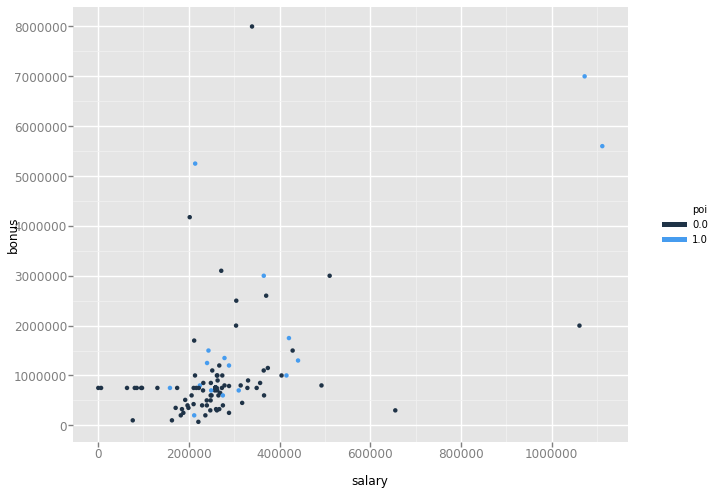

<ggplot: (16402885)>

In [17]:
ggplot(aes(x='salary',y='bonus',color='poi'),data=df_imputed)+geom_point()

## 2.2. Feature Selection

There are several email features:to messages, from messages,from poi to this person and from this person to poi. There variables only provide the number of emails of each category. However, I believe percentage of poi associated email will provide us with more information to identify other person of interest for further investigation.

Below, we calculate two fractions:

Fraction_from_poi: the percentage of email received from poi out of total messages received by this person

Fraction_to_poi: the precentage of email sent to poi out of total messages sent out by this person

In [18]:
df_imputed['fraction_from_poi']=df_imputed['from_poi_to_this_person']/df_imputed['from_messages']
df_imputed['fraction_to_poi']=df_imputed['from_this_person_to_poi']/df_imputed['to_messages']

In [19]:
df_imputed.shape

(144, 19)

In [20]:
features_list.append('fraction_from_poi')
features_list.append('fraction_to_poi')

In [21]:
df_imputed.head()

,bonus,deferral_payments,deferred_income,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,long_term_incentive,other,poi,restricted_stock,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value,fraction_from_poi,fraction_to_poi
0,600000.0,221063.5,-151927.0,1297049.0,94299.0,29.0,38.0,1.0,422158.0,1740.0,0.0,585062.0,365788.0,702.0,807.0,1061827.0,585062.0,1.310345,0.001239
1,1200000.0,1295738.0,-1386055.0,6680544.0,11200.0,41.0,35.0,8.0,1586055.0,2660303.0,0.0,3942714.0,267102.0,740.5,1211.0,5634343.0,10623258.0,0.853659,0.006606
2,350000.0,221063.5,-400729.0,4890344.0,78552.0,41.0,35.0,8.0,422158.0,12961.0,0.0,1788391.0,170941.0,740.5,1211.0,211725.0,6678735.0,0.853659,0.006606
3,750000.0,221063.5,-151927.0,651850.0,46547.5,12.0,10.0,0.0,422158.0,51984.5,0.0,386335.0,258741.0,58.0,764.0,1100246.5,1038185.0,0.833333,0.000000
4,1500000.0,221063.5,-3117011.0,5538001.0,34039.0,32.0,32.0,21.0,1617011.0,11350.0,1.0,853064.0,243293.0,1035.0,1045.0,288682.0,6391065.0,1.000000,0.020096


In [22]:
features_list.remove('from_poi_to_this_person')
features_list.remove('from_this_person_to_poi')
features_list.remove('from_messages')
features_list.remove('to_messages')

In [23]:
len(features_list)

15

In [24]:
df_imputed=df_imputed.drop('from_poi_to_this_person',1)
df_imputed=df_imputed.drop('from_this_person_to_poi',1)
df_imputed=df_imputed.drop('to_messages',1)
df_imputed=df_imputed.drop('from_messages',1)

In [25]:
df_imputed.shape

(144, 15)

First, we use all data for variable selection. Prepare the data by separating features and labels and rescale the features so that all variables are on the same sacle.

In [26]:
from sklearn import preprocessing
labels = df_imputed['poi'].astype(int).as_matrix()
features = df_imputed.drop('poi',1).as_matrix()
min_max_scaler = preprocessing.MinMaxScaler()
features_scaled=min_max_scaler.fit_transform(features)


In [27]:
features_scaled[1:5,]

array([[ 0.14249685,  0.21414199,  0.60462365,  0.19441665,  0.04834328,
         0.29881185,  0.25679258,  0.37700879,  0.24003381,  0.13381047,
         0.05440531,  0.21701823,  0.07407781,  0.03355123],
       [ 0.03530895,  0.04955418,  0.88585987,  0.14229276,  0.34295212,
         0.06952725,  0.0012509 ,  0.25295603,  0.15346319,  0.13381047,
         0.00204304,  0.13677024,  0.07407781,  0.03355123],
       [ 0.08575032,  0.04955418,  0.95687406,  0.01888377,  0.20295912,
         0.06952725,  0.00501775,  0.1722212 ,  0.23250668,  0.01014677,
         0.01062285,  0.02201803,  0.07231405,  0.        ],
       [ 0.18032787,  0.04955418,  0.11056633,  0.1611501 ,  0.14824487,
         0.3049101 ,  0.0010954 ,  0.19909693,  0.21859935,  0.18717159,
         0.00278616,  0.13091784,  0.08677686,  0.10206237]])

In [28]:
from sklearn.feature_selection import SelectKBest,chi2
kbest = SelectKBest(chi2)

features_kbest=kbest.fit_transform(features_scaled,labels)
features_selected=[features_list[i+1]for i in kbest.get_support(indices=True)]
feature_scores = ['%.2f' % elem for elem in kbest.scores_ ]
features_scores_selected=[feature_scores[i]for i in kbest.get_support(indices=True)]
print 'Selected Features', features_selected
print 'Feature Scores', features_scores_selected

Selected Features ['bonus', 'exercised_stock_options', 'long_term_incentive', 'other', 'salary', 'total_payments', 'total_stock_value', 'shared_receipt_with_poi', 'fraction_from_poi', 'fraction_to_poi']
Feature Scores ['2.37', '5.95', '1.14', '1.49', '0.69', '1.13', '2.49', '5.04', '0.79', '0.82']


Features with highest scores are exercised stock options, shared receipt with poi, bonus, total stock value

Next, we split the data into training and testing datasets and use the features we selected to train classifiers. Using training and testing datasets, or cross validation, is a method that is used to assess the performance of a classifier. We will use training set to fit the classifier and test the performance on testing dataset.

In [51]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features_scaled,labels,test_size=0.3,random_state=422)

## Build Classifier

With training and testing datasets, we are ready to build the classifiers. To evaluate the effectiveness of a classifier, accuracy score, precision rate and recall rate will be used. Accuracy score the proportion of the labels predicted correctly 

### 3.1 Gaussian Naive Bayes

In [52]:
from sklearn.naive_bayes import GaussianNB
g_clf = GaussianNB()
g_clf.fit(features_train,labels_train)
pred=g_clf.predict(features_test)

accuracy = accuracy_score(pred,labels_test)
recall=recall_score(labels_test,pred)
precision=precision_score(labels_test,pred)
print "The accuracy score of this classifier is: %s" % accuracy
print "The recall score of this classifier is: %s" % recall
print "The precision score of this classifier is: %s" % precision

The accuracy score of this classifier is: 0.886363636364
The recall score of this classifier is: 0.2
The precision score of this classifier is: 0.5


### 3.2 Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier
r_clf=RandomForestClassifier()
r_clf.fit(features_train,labels_train)
pred=r_clf.predict(features_test)


accuracy = accuracy_score(pred,labels_test)
recall=recall_score(labels_test,pred)
precision=precision_score(labels_test,pred)
print "The accuracy score of this classifier is: %s" % accuracy
print "The recall score of this classifier is: %s" % recall
print "The precision score of this classifier is: %s" % precision

The accuracy score of this classifier is: 0.909090909091
The recall score of this classifier is: 0.2
The precision score of this classifier is: 1.0


### 3.3 Adaboost Classifier

In [60]:
from sklearn.ensemble import AdaBoostClassifier
a_clf=AdaBoostClassifier()
a_clf.fit(features_train,labels_train)
pred=a_clf.predict(features_test)

accuracy = accuracy_score(pred,labels_test)
recall=recall_score(labels_test,pred)
precision=precision_score(labels_test,pred)
print "The accuracy score of this classifier is: %s" % accuracy
print "The recall score of this classifier is: %s" % recall
print "The precision score of this classifier is: %s" % precision

The accuracy score of this classifier is: 0.909090909091
The recall score of this classifier is: 0.6
The precision score of this classifier is: 0.6



### 3.4 Logistic Regression

In [67]:
from sklearn.linear_model import LogisticRegression
l_clf=LogisticRegression()
l_clf.fit(features_train,labels_train)
pred=l_clf.predict(features_test)

accuracy = accuracy_score(pred,labels_test)
recall=recall_score(labels_test,pred)
precision=precision_score(labels_test,pred)
print "The accuracy score of this classifier is: %s" % accuracy
print "The recall score of this classifier is: %s" % recall
print "The precision score of this classifier is: %s" % precision

The accuracy score of this classifier is: 0.886363636364
The recall score of this classifier is: 0.0
The precision score of this classifier is: 0.0


We tried 4 algorithms to classifier/predict person of interest. Amoung these, adaboost and random forest have the best performance regarding accuracy, precision and recall score. Next we will tune these algorithm and find the best parameter for prediction.

## 4. Tuning Classifier

From previous section, we can see that random forest and adaboost have the best prediction accuracy. In this section, we will use GridSearchCV to tune the parameters for Adaboost classifier to maximize the accuracy of prediction.

In [82]:
from sklearn.grid_search import GridSearchCV
a_clf=AdaBoostClassifier()
parameters={'n_estimators':[5,10,20,50,60,70,80,90,100],'learning_rate':[0.5,1,1.2,1.3,1.4,1.5,2 ],'algorithm':('SAMME','SAMME.R')}
gs=GridSearchCV(a_clf,parameters)
gs.fit(features_train,labels_train)
a_y_pred=gs.predict(features_test)


In [83]:
print gs.best_estimator_

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=2,
          n_estimators=20, random_state=None)


After we found the best model, we use the test.py program to test our results. The accuracy is 0.84487, precision rate is 0.368 and recall is 0.253.

## 5. Summary and Conclusion

In this project, we cleaned and studied the Enron dataset to build classifiers to identify if a person would be person of interest (POI) using financial features and email interactions between people. We first cleaned and impute the missing values and then calculated some ratios that would be useful in building classifiers. And next we built several classifiers using the training data and test the prediction power using test data. 

In the last section, we tuned the classifiers and tried to improve their predicting accuracy. I believe the random forest classifier is the best method, based on precision and recall rates, for identifying POI employee in this study.

## 6. Reference

sklearn help pages



http://stackoverflow.com/questions/22361781/how-does-sklearn-random-forest-index-feature-importances

https://stats.stackexchange.com/questions/58214/when-does-naive-bayes-perform-better-than-svm

http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

http://optunity.readthedocs.io/en/latest/notebooks/notebooks/sklearn-automated-classification.html
